In [1]:
import os
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from datetime import datetime as dt
import matplotlib.patches as mpatches

sns.set(rc={'axes.facecolor':'lightgray', 'figure.facecolor':'white'})
plt.rcParams['font.family'] = 'Times New Roman'

# Temporally plotting results

First, define the labels for the different metrics, the different colors for the themes and the on/offset periods.

In [2]:
color_onset = "#edf8b1"
color_offset = "#31a354"
color_twitter = "#1DA1F2"
mpd_color = "#A73B2D"

In [3]:
label_dict = {'no_real_movements': 'Number of movements', 
              'jl_simple_means_over_user_means': 'Mean movement distance',
              'graph_modularity': 'Graph modularity', 
              'rel_tweets_in_residential_areas': '% activity in residential area', 
              'mean_rog': 'Radius of gyration'}

wanted_stats = ['no_real_movements', 'jl_simple_means_over_user_means',\
                  'graph_modularity', 'rel_tweets_in_residential_areas', 'mean_rog']

In [4]:
onoff1_dates = pd.to_datetime(['2020-04-06', '2020-06-06'])
onoff2_dates = pd.to_datetime(['2021-04-06', '2021-06-06'])
onoff3_dates = pd.to_datetime(['2022-04-06', '2022-06-06'])

### Load Data
Load post-processed data.

In [5]:
# Load all Mobile Phone Data
mpd_pp = {}
path = "data/post_processing"
for file in [file for file in os.listdir(path)]:
    if ".csv" not in file or "mpd" not in file:
        continue
    data = pd.read_csv(os.path.join(path, file))
    data['date'] = data['date'].apply(lambda x: dt.strptime(str(x), "%Y-%m-%d"))
    data = data.set_index('date')
    mpd_pp[file.split(".csv")[0]] = data
    
mpd_trend = mpd_pp['mpd_trend28_scaled']

### Load different types of prepared twitter data
For trends (rolling averages) only 28 day trends are used here.

In [6]:
path_or = "data/post_processing/twitter/"

In [7]:
# twitter, no trends, not normalized, scaled
twitter_scaled= {}
path = path_or + "scaled"
for file in os.listdir(path):
    data = pd.read_csv(os.path.join(path, file))
    data['middle_date'] = data['middle_date'].apply(lambda x: dt.strptime(str(x), "%Y-%m-%d"))
    data = data.set_index('middle_date')

    key = file[:-4]

    if len(key) == 5:
        key = '0' + key

    twitter_scaled[key] = data
twitter_scaled.keys()

dict_keys(['11days', '13days', '15days', '17days', '19days', '01days', '21days', '23days', '25days', '27days', '29days', '31days', '03days', '05days', '07days', '09days'])

In [8]:
twitter_trend_scaled = {}
path = path_or + "trend_scaled"
for file in os.listdir(path):
    if '28' in file:
        data = pd.read_csv(os.path.join(path, file))
        data['middle_date'] = data['middle_date'].apply(lambda x: dt.strptime(str(x), "%Y-%m-%d"))
        data = data.set_index('middle_date')
        
        key = file[:-7]
        
        if len(key) == 5:
            key = '0' + key

        twitter_trend_scaled[key] = data
twitter_trend_scaled.keys()

dict_keys(['11days', '13days', '15days', '17days', '19days', '01days', '21days', '23days', '25days', '27days', '29days', '31days', '03days', '05days', '07days', '09days'])

### Load sample-based data

In [9]:
path_or = "data/post_processing/sample_based/"

In [10]:
sample_trend_scaled = {}
path = path_or + "trend_scaled"
for file in os.listdir(path):
    if '28' in file:
        data = pd.read_csv(os.path.join(path, file))
        data['middle_date'] = data['middle_date'].apply(lambda x: dt.strptime(str(x), "%Y-%m-%d"))
        data = data.set_index('middle_date')
        
        key = file[:-7]
        
        if len(key) == 5:
            key = '0' + key

        sample_trend_scaled[key] = data
sample_trend_scaled.keys()

dict_keys(['15days', '01days', '07days'])

In [11]:
# twitter, no trends, first normalized by tweet amount, then scaled
sample_scaled= {}
path = path_or + "scaled"
for file in os.listdir(path):
    data = pd.read_csv(os.path.join(path, file))
    data['middle_date'] = data['middle_date'].apply(lambda x: dt.strptime(str(x), "%Y-%m-%d"))
    data = data.set_index('middle_date')

    key = file[:-4]

    if len(key) == 5:
        key = '0' + key

    sample_scaled[key] = data
sample_scaled.keys()

dict_keys(['15days', '01days', '07days'])

In [12]:
# Load od matrices
path = "data/post_processing/"
ods = {name[:-4]: np.load(os.path.join(path, name)) for name in os.listdir(path) if "_od_" in name}

In [13]:
twitter_dicts = [twitter_scaled, twitter_trend_scaled]

In [14]:
twitter_sample_dicts = [sample_scaled, sample_trend_scaled]

# USED IN PAPER: Effect of rolling window down sampling - all possibilities
Plotting all the timeseries data that was loaded in before using three different rolling window sizes (1, 7 and 15 days).

In [15]:
for collection, sample in zip([twitter_dicts, twitter_sample_dicts], [False, True]):
    for j, twitter_dict in enumerate(collection):
        fig, axs = plt.subplots(5, figsize=(10, 14), sharex=True)
        for i, stat in enumerate(wanted_stats):
            twitter_dict['01days'][stat].plot(ax=axs[i], color='#6baed6')
            twitter_dict['07days'][stat].plot(ax=axs[i], color='#3182bd')
            twitter_dict['15days'][stat].plot(ax=axs[i], color='#08519c')
            
            if i == 0:
                axs[i].legend(['1', '7', '15'], title='Rolling window size', loc='lower right', fontsize=12)

            axs[i].set_ylabel(label_dict[stat], size=15)
            
            axs[i].set_xlabel('Date', size=15)

            axs[i].tick_params(axis='x', which='major', labelsize=15)
            axs[i].tick_params(axis='y', which='major', labelsize=12)

        p = f"result_plots/figure_appendix_a3/figure_appendix_a3_{j+1}.png"
        if sample:
            p = f"result_plots/figure_appendix_a3/figure_appendix_a3_{j+3}.png"
        fig.savefig(p)
        plt.close()

# USED IN PAPER: Effect of 28 day moving average additional effect of rolling window down sampling

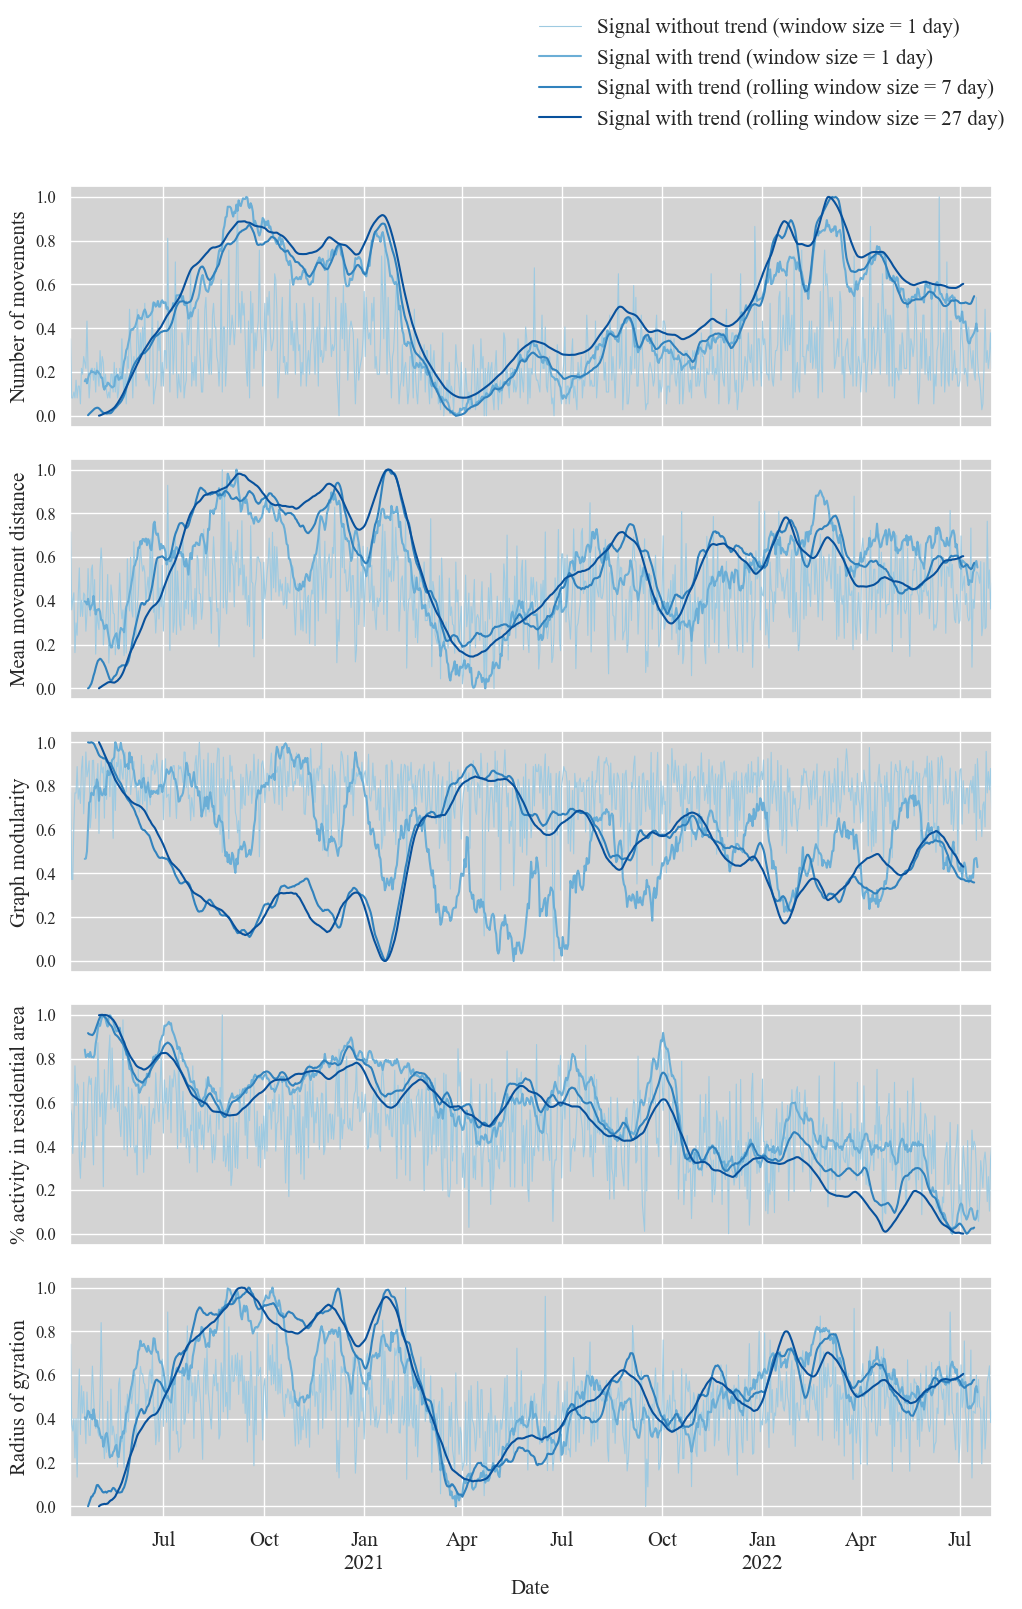

In [16]:
fig, axs = plt.subplots(5, figsize=(10, 14), sharex=True)
fig.tight_layout()
for i, stat in enumerate(wanted_stats):
    twitter_scaled['01days'][stat].plot(ax=axs[i], color='#9ecae1', linewidth=0.8)
    twitter_trend_scaled['01days'][stat].plot(ax=axs[i], color='#6baed6')
    twitter_trend_scaled['07days'][stat].plot(ax=axs[i], color='#3182bd')
    twitter_trend_scaled['27days'][stat].plot(ax=axs[i], color='#08519c')
    
    if i == 0:
        legend = axs[i].legend(['Signal without trend (window size = 1 day)',\
                       'Signal with trend (window size = 1 day)', \
                       'Signal with trend (rolling window size = 7 day)',\
                       'Signal with trend (rolling window size = 27 day)'], loc=(0.5, 1.2), prop={'size': 15})
    
        frame = legend.get_frame()
        frame.set_color('white')

    axs[i].set_ylabel(label_dict[stat], size=15)
    axs[i].set_xlabel('Date', size=15)
    axs[i].tick_params(axis='x', which='major', labelsize=15)
    axs[i].tick_params(axis='y', which='major', labelsize=12)

# USED IN PAPER: Tweet volume over time
Show the tweet volume over time.

In [17]:
# Due to data regulations, this dataset can not be provided in this form. If the respective Tweets from data/all_tweet_ids.csv
# Are downloaded and preprocessed with the previous notebooks, this file will reproduced.
tweets_raw = pd.read_csv('data/tweets/preprocessed_tweets_with_poi_location.csv')

In [18]:
tweets_raw['day'] = pd.to_datetime(tweets_raw.Timestamp).apply(lambda x: x.date())

In [19]:
sdiv = round(tweets_raw.groupby('User_ID').size().std(), 2)
print(f"Standard deviation of daily tweet amount:\n#########\n# {sdiv} #\n#########")

Standard deviation of daily tweet amount:
#########
# 20.96 #
#########


In [20]:
user_per_day = tweets_raw.groupby('day')['User_ID'].nunique()
user_per_day.index = pd.to_datetime(user_per_day.index)

In [21]:
raw_num = tweets_raw.groupby('day').size()
raw_num.index = pd.to_datetime(raw_num.index)

In [22]:
tweets_per_user = raw_num / user_per_day

In [23]:
tweets_raw.User_ID.nunique()

107500

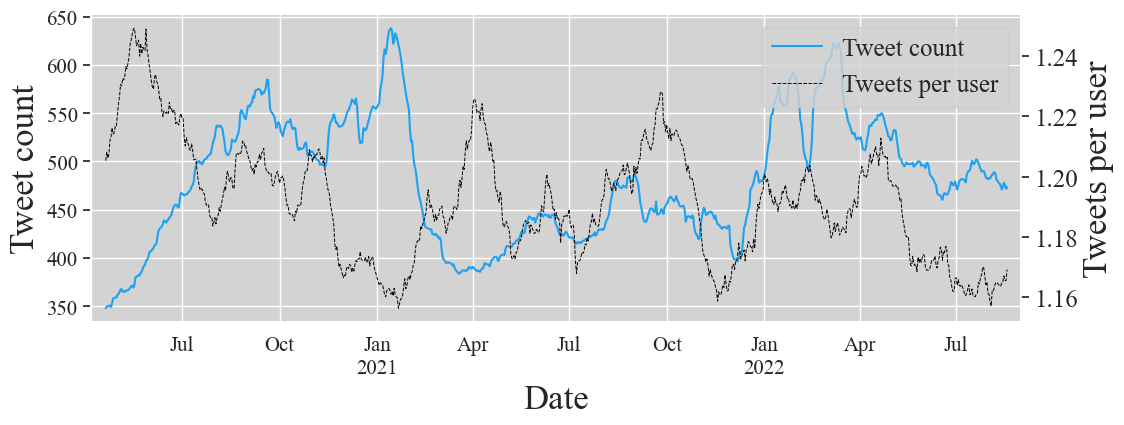

In [24]:
fig, ax = plt.subplots(1, figsize=(12, 4))

ax.set_xlabel('Tweets per day')
ax2 = ax.twinx()

raw_num.rolling(28, center=True).mean().plot(ax=ax, color=color_twitter, zorder=5, label='b')

tweets_per_user.rolling(28, center=True).mean().plot(ax=ax2, color='black', linestyle='--', zorder=-5, linewidth=0.7, label="a")

ax.set_ylabel("Tweet count", fontsize=25)
ax.set_xlabel("Date", fontsize=25)
ax2.set_ylabel("Tweets per user", fontsize=25)
ax2.grid(False)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)

handles, labels = ax.get_legend_handles_labels()

handle2, _ = ax2.get_legend_handles_labels()
handles.extend([handle2[0]])

ax.legend(["Tweet count"], fontsize="25", loc='upper right')
ax.tick_params(axis='both', which='major', labelsize=15)
legend = ax.legend(handles=handles, labels=['Tweet count', 'Tweets per user'], loc='upper right', fontsize="18")

# Correlations with mobile phone data
First, define the correlation function, that automatically omits dates where twitter or mobile phone data do not have values.

In [25]:
def corr(ts1, ts2):
    # drop out of bound times and return r and p value
    ts1 = ts1.dropna()
    ts2 = ts2.dropna()
    idx = ts1.index.intersection(ts2.index)
    ts1 = ts1.loc[idx]
    ts2 = ts2.loc[idx]
    return pearsonr(ts1, ts2)

### Create table template
An empty table where the correlation values are written in later.

In [26]:
table = pd.DataFrame()

twitter_mpd_trend = copy.deepcopy(table)
twitter_mpd_trend_untilokt = copy.deepcopy(table)

### Calculate correlations
Calculate the correlations for each rolling window size and each metric between twitter and mobile phone data. To give an perspective the correlation without a moving average is also shown.

In [27]:
# twitter_mpd_trend - correlations for each window size and metric
for stat in wanted_stats:
    for key, val in twitter_trend_scaled.items():
        key = key[:2]
        correlation = corr(mpd_trend[stat], val[stat])[0]
        #print(correlation)
        twitter_mpd_trend.loc[stat, key] = correlation
        twitter_mpd_trend = twitter_mpd_trend.sort_index(axis=1)

plot_table = copy.deepcopy(twitter_mpd_trend)
    
notrend = []
for stat in wanted_stats:
    val = twitter_scaled['01days']
    correlation = corr(mpd_trend[stat], val[stat])[0]
    notrend.append(correlation)
    
# plot_table['notrend'] = notrend
# plot_table = plot_table.sort_index(axis=1)

plot_table.loc['mean'] = plot_table.mean()
plot_table

,01,03,05,07,09,11,13,15,17,19,21,23,25,27,29,31
no_real_movements,0.171477,0.285248,0.318545,0.339011,0.351185,0.357861,0.360507,0.361350,0.361297,0.359463,0.356435,0.353112,0.349124,0.344595,0.339506,0.334084
jl_simple_means_over_user_means,0.231449,0.366324,0.439570,0.471255,0.483991,0.484700,0.478108,0.468933,0.461107,0.455721,0.450162,0.442015,0.432807,0.424244,0.415476,0.406489
graph_modularity,0.354809,0.395059,0.409687,0.407788,0.397135,0.387644,0.383661,0.376458,0.367034,0.359399,0.356869,0.352397,0.349587,0.356388,0.355644,0.358248
rel_tweets_in_residential_areas,0.349421,0.320229,0.345011,0.357166,0.370061,0.377548,0.380207,0.380031,0.377854,0.374342,0.371215,0.367320,0.363699,0.359411,0.355103,0.350760
mean_rog,0.109762,0.196419,0.297050,0.363617,0.393058,0.397271,0.397263,0.397245,0.391773,0.386376,0.381607,0.376690,0.371372,0.362450,0.352441,0.340592
mean,0.243384,0.312656,0.361973,0.387767,0.399086,0.401005,0.399949,0.396803,0.391813,0.387060,0.383257,0.378307,0.373318,0.369418,0.363634,0.358035


# USED IN PAPER: Trends vs. trends correlation table
The table in converted to latex with bold formatting for the rolling window size used later for the mobile phone comparison (11 days).

In [28]:
temp = copy.deepcopy(plot_table)
temp.index = [label_dict[idx] if idx in label_dict else 'mean' for idx in list(temp.index)]
styler = temp.style
styler = styler.set_properties(subset=['11'], **{'font-weight': 'bold'})
styler = styler.format(precision=3)
styler.to_latex("result_plots/LATEX_correlation_table_total.tex")
styler

,01,03,05,07,09,11,13,15,17,19,21,23,25,27,29,31
Number of movements,0.171,0.285,0.319,0.339,0.351,0.358,0.361,0.361,0.361,0.359,0.356,0.353,0.349,0.345,0.340,0.334
Mean movement distance,0.231,0.366,0.440,0.471,0.484,0.485,0.478,0.469,0.461,0.456,0.450,0.442,0.433,0.424,0.415,0.406
Graph modularity,0.355,0.395,0.410,0.408,0.397,0.388,0.384,0.376,0.367,0.359,0.357,0.352,0.350,0.356,0.356,0.358
% activity in residential area,0.349,0.320,0.345,0.357,0.370,0.378,0.380,0.380,0.378,0.374,0.371,0.367,0.364,0.359,0.355,0.351
Radius of gyration,0.110,0.196,0.297,0.364,0.393,0.397,0.397,0.397,0.392,0.386,0.382,0.377,0.371,0.362,0.352,0.341
mean,0.243,0.313,0.362,0.388,0.399,0.401,0.400,0.397,0.392,0.387,0.383,0.378,0.373,0.369,0.364,0.358


# USED IN PAPER: Correlations over rolling window sizes
All five metrics and their correlations are plotted depending on rolling window size.

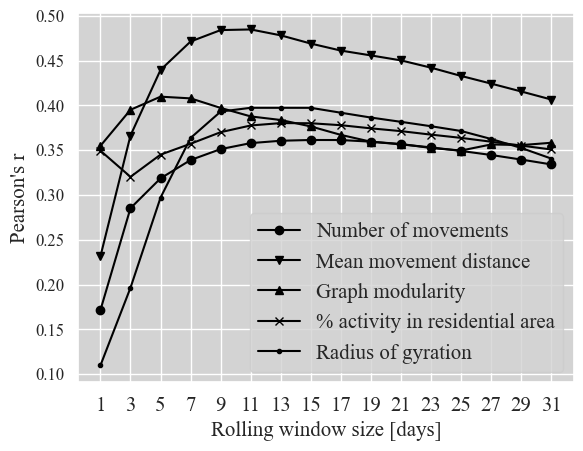

In [29]:
fig, ax = plt.subplots(1)
twitter_mpd_trend.columns = [str(x) for x in np.arange(1, 33, 2)]
twitter_mpd_trend_T = twitter_mpd_trend.T
marker_list = ['o', 'v', '^', 'x', '.']
for i, column in enumerate(twitter_mpd_trend_T.columns):
    ax.plot(twitter_mpd_trend_T.index, twitter_mpd_trend_T[column], marker=marker_list[i], color='black')
ax.set_ylabel(r"Pearson's r", size=15)
ax.set_xlabel('Rolling window size [days]', size=15)
ax.legend([label_dict[stat] for stat in wanted_stats], fontsize=15)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=12)

# USED IN PAPER: Metrics with mpd and twitter
Use the rolling window for twitter with the highest correlation and the mobile phone data to create a plot comparing the five metrics over time.

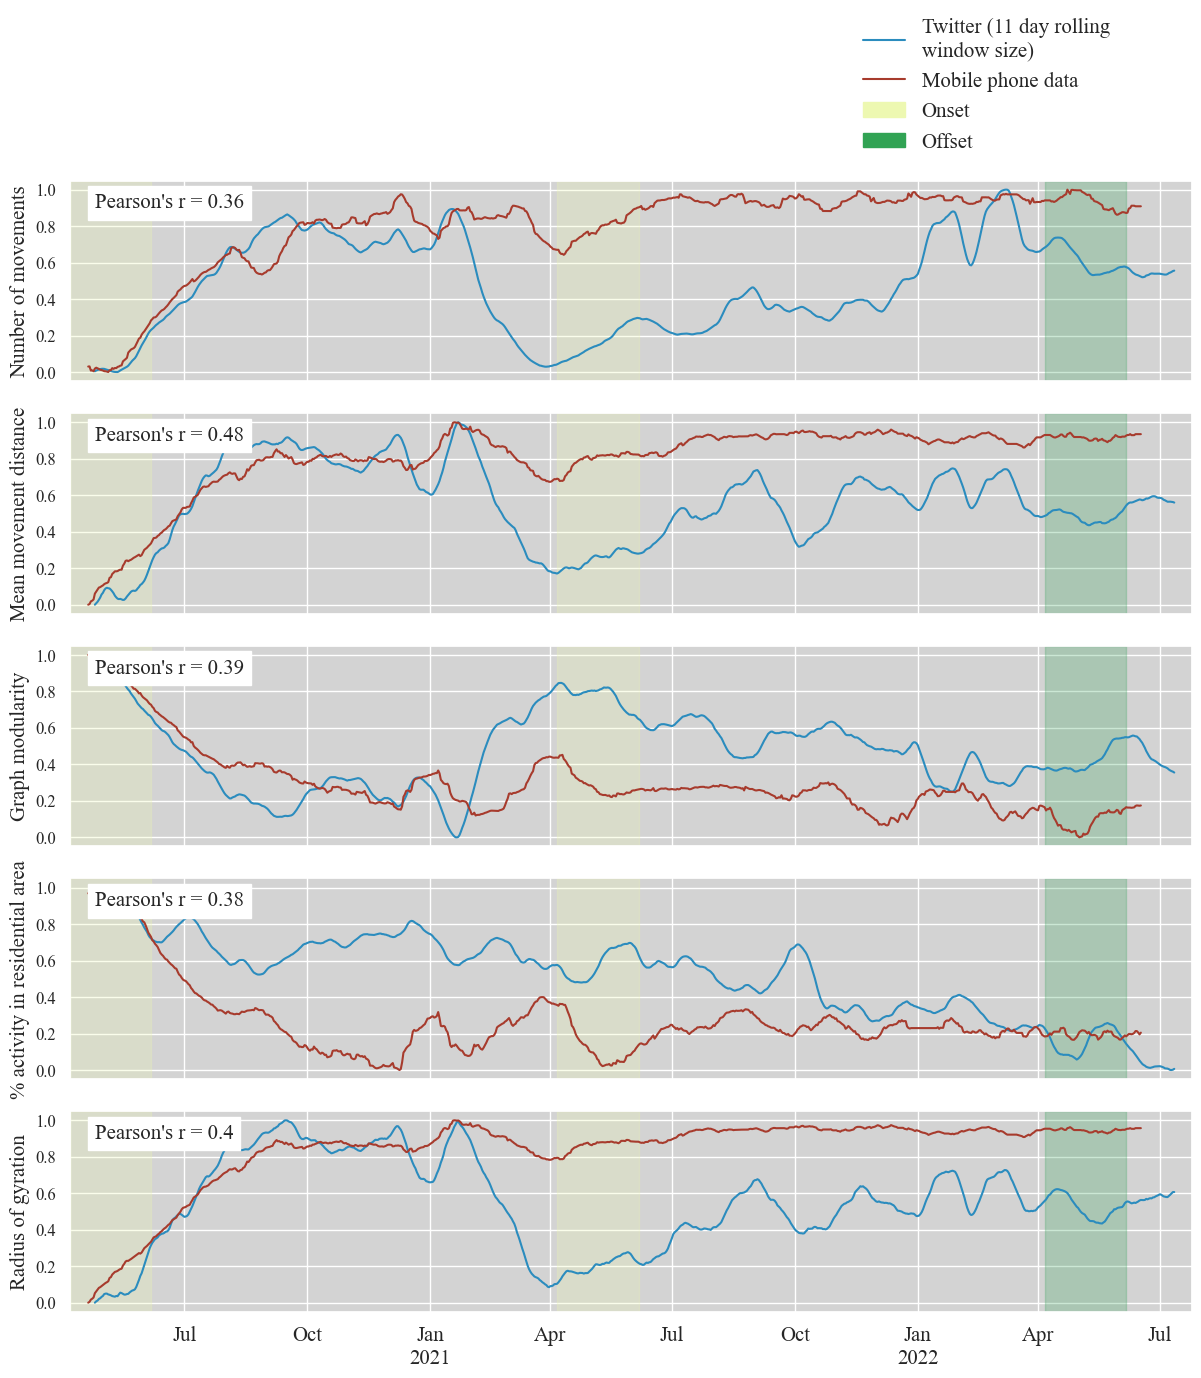

In [30]:
wanted_subsets = ['11days']

fig, axs = plt.subplots(5, figsize=(12, 12), sharex=True)
fig.tight_layout()
for i, stat in enumerate(wanted_stats):
    leg = []
    for sub in wanted_subsets:
        df = twitter_trend_scaled[sub][stat]
        df.plot(ax=axs[i], color='#2b8cbe', linestyle='solid')
        leg.append(f'Twitter (11 day rolling\nwindow size)')
        
    mpd_trend[stat].plot(ax=axs[i], color=mpd_color)
    
    pearsonr = round(df.corr(mpd_trend[stat]), 2)
   
    leg.extend(['Mobile phone data', 'Onset', 'Offset'])
    
    
    red_patch = mpatches.Patch(color=color_onset)
    green_patch = mpatches.Patch(color=color_offset)
    handles, labels = axs[i].get_legend_handles_labels()
    handles.extend([red_patch, green_patch])
    
    if i == 0:
        axs[i].legend(leg, loc='best')
        legend = axs[i].legend(handles=handles, labels=leg, fontsize=15, loc=(0.7, 1.1))
        
        frame = legend.get_frame()
        frame.set_color('white')
    
    t = axs[i].text('2020-04-25', 0.9, r"Pearson's r = " +str(pearsonr), backgroundcolor='white', size=15)
    
    axs[i].set_ylabel(label_dict[stat], size=15)
    axs[i].set_xlabel('')
    
    axs[i].axvspan(onoff1_dates[0], onoff1_dates[1], color=color_onset, alpha=0.25)
    axs[i].axvspan(onoff2_dates[0], onoff2_dates[1], color=color_onset, alpha=0.25)
    axs[i].axvspan(onoff3_dates[0], onoff3_dates[1], color=color_offset, alpha=0.25)

    
    axs[i].tick_params(axis='x', which='major', labelsize=15)
    axs[i].tick_params(axis='y', which='major', labelsize=12)

# USED IN PAPER: Moving window synchrony
To show times of higher and lower correlations a moving window of 60 days is defined. A correlations between twitter and mpd is calculated for that window and plotted in a second graph below.

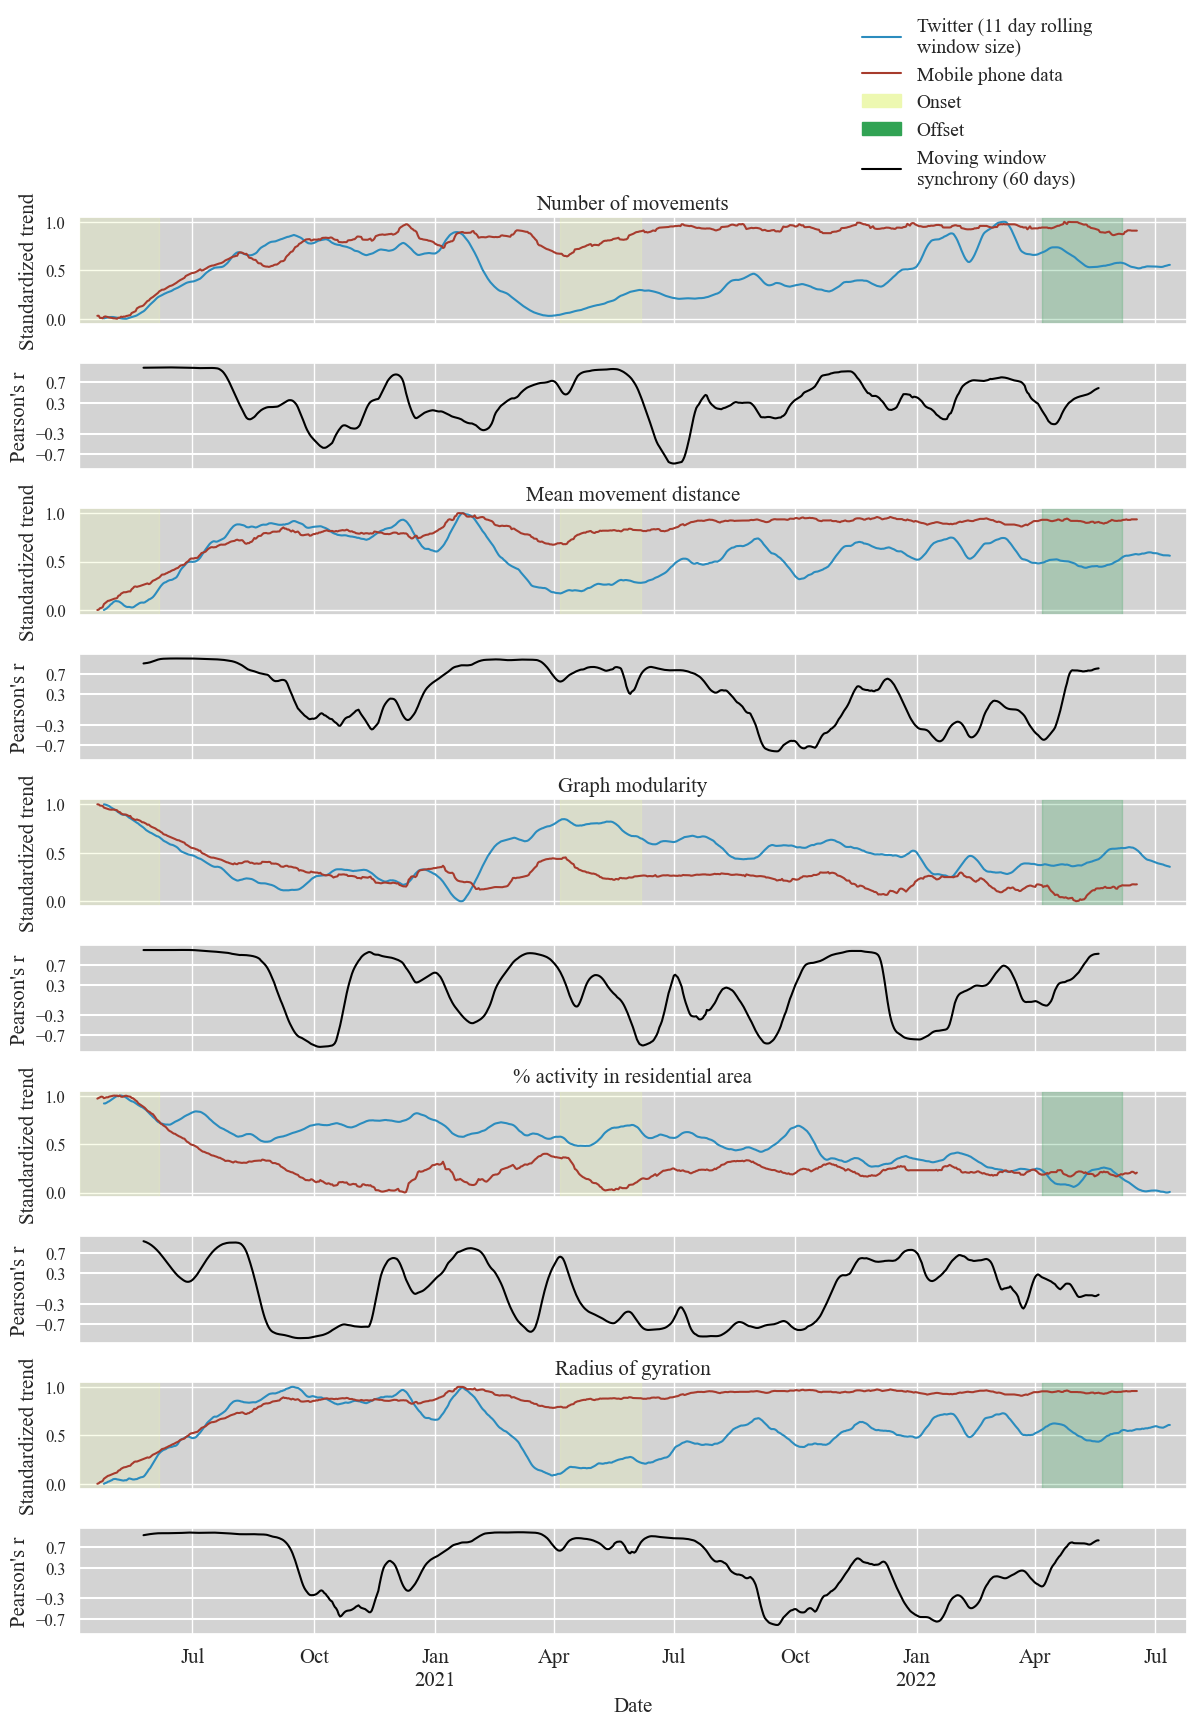

In [31]:
#sns.set_style("whitegrid", {"grid.color": "0.7", "grid.linestyle": "-"})
wanted_stats = ['no_real_movements', 'jl_simple_means_over_user_means', \
                'graph_modularity', 'rel_tweets_in_residential_areas', 'mean_rog']

r_window_size = 60

fig, ax = plt.subplots(10, 1, figsize=(12,15), sharex=True)
fig.tight_layout(pad=1.5)

for i, stat in enumerate(wanted_stats):
    i *= 2
    
    leg = []
    leg.extend(['Twitter (11 day rolling\nwindow size)', 'Mobile phone data', 'Onset', 'Offset', 'Moving window\nsynchrony (60 days)'])
    
    df_twitter = twitter_trend_scaled['11days'][stat]
    df_mpd = mpd_trend[stat]
    rolling_r = df_twitter.rolling(window=r_window_size, center=True).corr(df_mpd)

    df_twitter.plot(ax=ax[i], color='#2b8cbe')
    ax[i].set_title(label_dict[stat], size=15)
    ax[i].set_ylabel('Standardized trend', size=15)
    ax[i].set_yticks([0.0, 0.5, 1])
    
    df_mpd.plot(ax=ax[i], color=mpd_color)
    
    ax[i].axvspan(onoff1_dates[0], onoff1_dates[1], color=color_onset, alpha=0.25)
    ax[i].axvspan(onoff2_dates[0], onoff2_dates[1], color=color_onset, alpha=0.25)
    ax[i].axvspan(onoff3_dates[0], onoff3_dates[1], color=color_offset, alpha=0.25)
    
    rolling_r.plot(ax=ax[i+1], color='black')
    ax[i+1].set_xlabel('Date', size=15)
    ax[i+1].set_ylabel(r"Pearson's r", size=15)
    ax[i+1].set_zorder(5)
    ax[i+1].set_yticks([-1.0, 0.0, 1.0])
    
    ax[i+1].yaxis.grid(False) # Hide the horizontal gridlines
    ax[i+1].xaxis.grid(True) # Show the vertical gridlines
    
    ax[i+1].axhline(y=0.7, color='white', linestyle='-', zorder=0)
    ax[i+1].axhline(y=-0.7, color='white', linestyle='-', zorder=0)
    ax[i+1].axhline(y=0.3, color='white', linestyle='-', zorder=0)
    ax[i+1].axhline(y=-0.3, color='white', linestyle='-', zorder=0)
    
    custom_y_ticks = [-0.7, -0.3, 0.3, 0.7]  # Add 0.7 to the ticks
    ax[i+1].set_yticks(custom_y_ticks)
    
    
    

    if i==0:
        red_patch = mpatches.Patch(color=color_onset)
        green_patch = mpatches.Patch(color=color_offset)
        handles, labels = ax[i].get_legend_handles_labels()
        
        handle2, _ = ax[i+1].get_legend_handles_labels()
        
        handles.extend([red_patch, green_patch, handle2[0]])
        legend = ax[i].legend(handles=handles, labels=leg, loc=(0.7, 1.2), fontsize=14)
        
        frame = legend.get_frame()
        frame.set_color('white')
        
    ax[i+1].tick_params(axis='x', which='major', labelsize=15)
    ax[i+1].tick_params(axis='y', which='major', labelsize=12)
    ax[i].tick_params(axis='y', which='major', labelsize=12)

# USED IN PAPER: Onset vs offset / weekday vs weekend boxplots
This plot illustrates how the metrics differ in the defined onest / offset periods. As a comparison we also plotted another comparison: weekdays and weekends.

In [32]:
twitter = twitter_trend_scaled['11days']
mpd = mpd_trend

In [33]:
# Set Lockdown and Post-Lockdown periods
mask = (twitter.index >= onoff1_dates[0]) & (twitter.index <= onoff1_dates[1])
twitter.loc[mask, 'type'] = 'onoff1'
mask = (mpd.index >= onoff1_dates[0]) & (mpd.index <= onoff1_dates[1])
mpd.loc[mask, 'type'] = 'onoff1'

mask = (twitter.index >= onoff2_dates[0]) & (twitter.index <= onoff2_dates[1])
twitter.loc[mask, 'type'] = 'onoff2'
mask = (mpd.index >= onoff2_dates[0]) & (mpd.index <= onoff2_dates[1])
mpd.loc[mask, 'type'] = 'onoff2'

mask = (twitter.index >= onoff3_dates[0]) & (twitter.index <= onoff3_dates[1])
twitter.loc[mask, 'type'] = 'onoff3'
mask = (mpd.index >= onoff3_dates[0]) & (mpd.index <= onoff3_dates[1])
mpd.loc[mask, 'type'] = 'onoff3'

In [34]:
# Set Weekday and Weekend Periods
mask = (twitter.index.weekday == 5) | (twitter.index.weekday == 6)
twitter.loc[mask, 'type2'] = 'weekend'
twitter.loc[~mask, 'type2'] = 'weekday'

mask = (mpd.index.weekday == 5) | (mpd.index.weekday == 6)
mpd.loc[mask, 'type2'] = 'weekend'
mpd.loc[~mask, 'type2'] = 'weekday'

In [35]:
df_twitter = {'numbers': [],
     'onoffs': [],
     'weekdays': [],
     'stats': []}

df_mpd = {'numbers': [],
     'onoffs': [],
     'weekdays': [],
     'stats': []}

for col in wanted_stats:
    numbers = twitter[col].values
    types = twitter['type']
    types2 = twitter['type2']
    stats = [col] * len(twitter)
    
    df_twitter['numbers'].extend(numbers)
    df_twitter['onoffs'].extend(types)
    df_twitter['weekdays'].extend(types2)
    df_twitter['stats'].extend(stats)
    
    numbers = mpd[col].values
    types = mpd['type']
    types2 = mpd['type2']
    stats = [col] * len(mpd)
    
    df_mpd['numbers'].extend(numbers)
    df_mpd['onoffs'].extend(types)
    df_mpd['weekdays'].extend(types2)
    df_mpd['stats'].extend(stats)
    
df_twitter = pd.DataFrame(df_twitter)
df_mpd = pd.DataFrame(df_mpd)

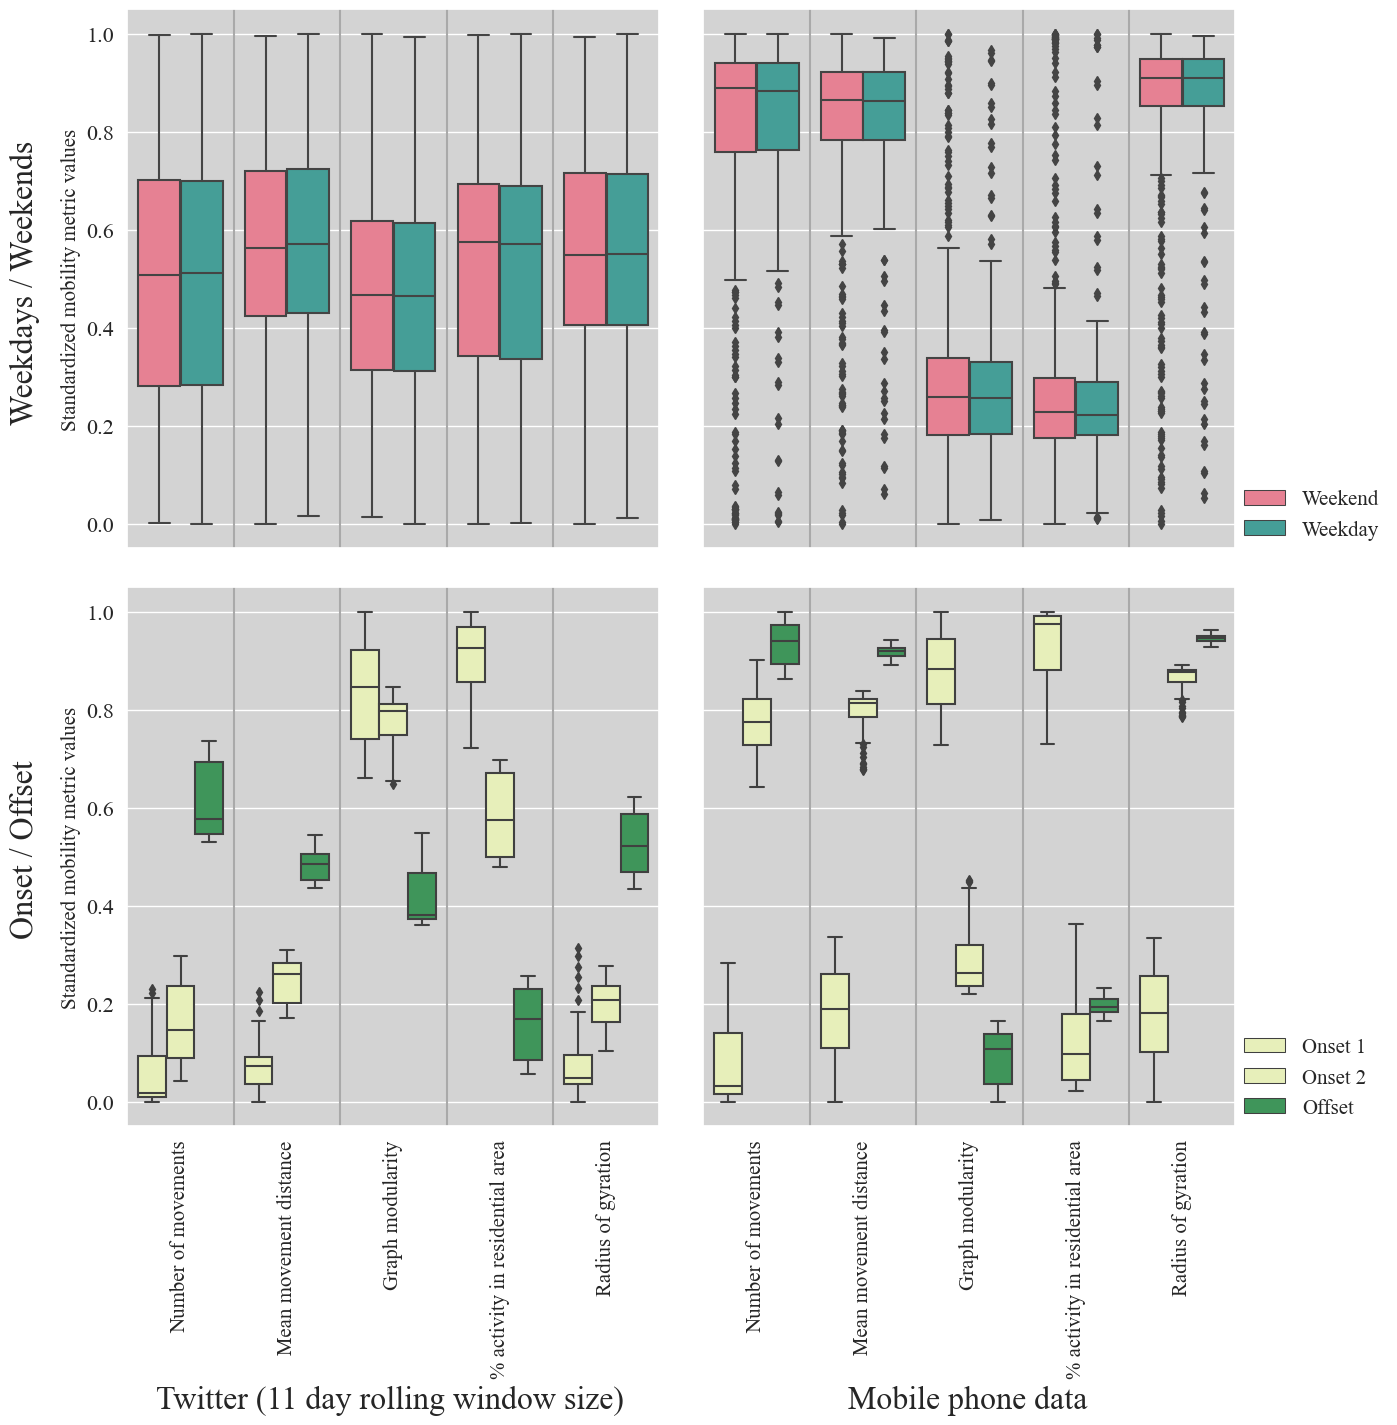

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharey=True, sharex=True)
fig.tight_layout(pad=1.5)
fig.supxlabel('Twitter (11 day rolling window size)                            Mobile phone data', 
              fontsize=23, y=-0.197, x=0.46)
fig.supylabel('          Onset / Offset                                          Weekdays / Weekends', 
              fontsize=23, x=-0.05)

box_colors = sns.color_palette([color_onset, color_onset, color_offset])

sns.boxplot(data=df_twitter, x="stats", y="numbers", hue="weekdays", palette='husl', orient='v', ax=axs[0,0])
sns.boxplot(data=df_mpd, x="stats", y="numbers", hue="weekdays", palette='husl', orient='v', ax=axs[0,1])
sns.boxplot(data=df_twitter, x="stats", y="numbers", hue="onoffs", palette=box_colors, orient='v', ax=axs[1,0])
sns.boxplot(data=df_mpd, x="stats", y="numbers", hue="onoffs", palette=box_colors, orient='v', ax=axs[1,1])

labels = [label_dict[stat] for stat in wanted_stats]

for i, x in enumerate(axs):
    for j, ax in enumerate(x):
    
        ax.set_xticklabels(labels, rotation=90, size=15)
        ax.tick_params(axis='y', which='major', labelsize=16)


        if i == 1:
            legend = ax.legend(fontsize=15, loc=(1, 0))
            legend.get_texts()[0].set_text("Onset 1")
            legend.get_texts()[1].set_text("Onset 2")
            legend.get_texts()[2].set_text("Offset")
        elif i == 0:
            legend = ax.legend(fontsize=15, loc=(1, 0))
            legend.get_texts()[0].set_text("Weekend")
            legend.get_texts()[1].set_text("Weekday")
            
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_edgecolor('white')
        if j == 0:
            ax.legend([], [], frameon=False)

        ax.set_xlabel('')
        
        
        if j % 2 == 0:
            ax.set_ylabel('Standardized mobility metric values', size=15)
        else:
            ax.set_ylabel('')
            
        for k in range(4):
            ax.axvline(x = k+0.5, ymin = 0, ymax = 1, color='darkgray')

# ADDITION: Testing for significance
The following section tests the subsets from the plot above for significance. The shapiro tests shows, that most of the datasets are not normally distributed, therefore a Mann-Whitney U test is chosen to perform the significance analyses later on. The final table then shows p-values for each combination showed in the plot above.

In [37]:
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro

In [38]:
for stat in wanted_stats:
    for period in ["weekday", "weekend"]:
        period = "onoff" + str(i+1)
        for data in [df_twitter, df_mpd]:
            data = data[data['onoffs'] == period]
            data = data[data['stats'] == stat].dropna()['numbers']
            _, p_value = shapiro(data)
            if p_value > 0.005:
                print("Likely normally distributed.")
            else:
                print("Likely not normally distributed.")
                
    for period in ["weekday", "weekend"]:
        for data in [df_twitter, df_mpd]:
            data = data[data['weekdays'] == period]
            data = data[data['stats'] == stat].dropna()['numbers']
            _, p_value = shapiro(data)
            if p_value > 0.005:
                print("Likely normally distributed.")
            else:
                print("Likely not normally distributed.")

Likely not normally distributed.
Likely normally distributed.
Likely not normally distributed.
Likely normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normally distributed.
Likely not normall

In [39]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [40]:
def calc_ps(data_t=df_twitter, which="- Twitter", groups=[[1, 2], [1, 3], [2, 3]], \
               cols = ["onset 1", "onset 2", "offset"]):
    df = pd.DataFrame()
    for stat in wanted_stats:
        for ta, tb in groups:
            col = cols[ta-1] + " vs. " + cols[tb-1]
            data = data_t[data_t['stats'] == stat]
            data = data.dropna()
            
            data_a = data[data['onoffs'] == "onoff"+str(ta)]['numbers']
            data_b = data[data['onoffs'] == "onoff"+str(tb)]['numbers']
            
            if cols[0] == "weekday":
                data_a = data[data['weekdays'] == "weekday"]['numbers']
                data_b = data[data['weekdays'] == "weekend"]['numbers']
            
            st, p_val = mannwhitneyu(data_a, data_b)

            if p_val < 0.005:
                s = '{:e}'.format(p_val)
                s = str(s)[:5] + str(s)[-4:] +  "***"
                df.loc[label_dict[stat] + which, col] = s
            else:
                df.loc[label_dict[stat] + which, col] = str(round(p_val, 3))
                
    return df
        

In [41]:
df1 = calc_ps(data_t=df_mpd, which="- MPD", groups=[[1, 2]], cols= ["weekday", "weekend"])
df2 = calc_ps(data_t=df_mpd, which="- MPD")
df3 = calc_ps(data_t=df_twitter, which="- Twitter", groups=[[1, 2]], cols= ["weekday", "weekend"])
df4 = calc_ps()

df_c_mpd = pd.concat([df1, df2], axis=1)
df_t_mpd = pd.concat([df3, df4], axis=1)
df_f = pd.concat([df_c_mpd, df_t_mpd], axis=0)
df_f.to_latex("result_plots/significances.txt")
df_f

,weekday vs. weekend,onset 1 vs. onset 2,onset 1 vs. offset,onset 2 vs. offset
Number of movements- MPD,0.736,3.091e-19***,3.072e-19***,1.006e-19***
Mean movement distance- MPD,0.642,3.091e-19***,3.075e-19***,7.770e-22***
Graph modularity- MPD,0.825,3.091e-19***,3.091e-19***,7.802e-22***
% activity in residential area- MPD,0.708,3.091e-19***,3.085e-19***,5.443e-07***
Radius of gyration- MPD,0.64,3.091e-19***,3.075e-19***,7.769e-22***
Number of movements- Twitter,0.961,4.076e-09***,3.849e-18***,7.801e-22***
Mean movement distance- Twitter,0.962,4.356e-17***,3.851e-18***,7.802e-22***
Graph modularity- Twitter,0.948,2.217e-03***,3.851e-18***,7.802e-22***
% activity in residential area- Twitter,0.923,3.851e-18***,3.851e-18***,7.802e-22***
Radius of gyration- Twitter,0.923,1.975e-10***,3.851e-18***,7.802e-22***


While all weekday vs. weekend combinations show high no significance, the onset - offset comparisons all show high significance, showing that data from these periods can be sufficiantly differentiated and change can be detected.